1. 데이터 로드

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Matplotlib 한글 폰트 설정 (Colab 환경용)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 구글 코랩에 드라이브 가져오기
from google.colab import drive
drive.mount('/content/drive')

try:
    movies_df = pd.read_csv('/content/drive/MyDrive/bigData/game_recommend_system/movie_dataset/movies.csv')
    ratings_df = pd.read_csv('/content/drive/MyDrive/bigData/game_recommend_system/movie_dataset/ratings.csv')
    tags_df = pd.read_csv('/content/drive/MyDrive/bigData/game_recommend_system/movie_dataset/tags.csv')
    print("✅ 데이터 로드 성공: MovieLens 핵심 파일")
except Exception as e:
    print(f"FATAL ERROR: 데이터 파일을 찾을 수 없습니다. {e}")
    exit()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,012 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126441 files and dire

2. 협업적 임베딩

In [2]:
# 2a. 사용자-아이템 평점 희소 행렬 생성
user_ids = ratings_df['userId'].unique()
movie_ids_collab = ratings_df['movieId'].unique()
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids_collab)}

ratings_df['user_index'] = ratings_df['userId'].map(user_to_index)
ratings_df['movie_index'] = ratings_df['movieId'].map(movie_to_index)

# 희소 행렬 (CSR Matrix) 생성
rating_matrix = csr_matrix((
    ratings_df['rating'].values,
    (ratings_df['user_index'].values, ratings_df['movie_index'].values)
), shape=(len(user_ids), len(movie_ids_collab)))

# 2b. Truncated SVD 적용 (행렬 분해)
n_components = 50 # 잠재 요인 차원 설정
svd = TruncatedSVD(n_components=n_components, random_state=42)
# 영화 임베딩 행렬 (Movies x Components) 획득
movie_collaborative_embeddings = svd.fit_transform(rating_matrix.T)
print(f"✅ 협업적 임베딩 생성 완료: {movie_collaborative_embeddings.shape}")

✅ 협업적 임베딩 생성 완료: (9724, 50)


In [ ]:
3. 콘텐츠 임베딩

In [3]:
# 3a. 태그 데이터 그룹화 (하나의 영화에 모든 태그를 결합)
movie_tags_df = tags_df.groupby('movieId')['tag'].apply(lambda x: " ".join(x)).reset_index()
movies_with_tags_df = movies_df[['movieId']].merge(movie_tags_df, on='movieId', how='left').fillna('')
content_movie_ids = movies_with_tags_df['movieId'].values # 콘텐츠 매트릭스와 맵핑될 Movie IDs

# 3b. TF-IDF 벡터화 적용
tfidf = TfidfVectorizer(stop_words='english')
tag_tfidf_matrix = tfidf.fit_transform(movies_with_tags_df['tag'].values)
movie_content_embeddings_tags = tag_tfidf_matrix.toarray()
print(f"✅ 콘텐츠 임베딩 생성 완료: {movie_content_embeddings_tags.shape}")


✅ 콘텐츠 임베딩 생성 완료: (9742, 1673)


4. 하이브리드 임베딩 정렬 및 결합

In [4]:
all_movie_ids = movies_df['movieId'].unique()
n_movies = len(all_movie_ids)
n_tag_features = movie_content_embeddings_tags.shape[1]

# 4a. 정렬을 위한 최종 행렬 초기화 (모든 영화 포함)
aligned_collaborative_embed = np.zeros((n_movies, n_components))
aligned_content_embed = np.zeros((n_movies, n_tag_features))

# 4b. Collaborative Embeddings 정렬 (평점이 없는 영화는 0으로 채워짐)
for i, movie_id in enumerate(all_movie_ids):
    if movie_id in movie_to_index:
        collab_index = movie_to_index[movie_id]
        aligned_collaborative_embed[i] = movie_collaborative_embeddings[collab_index]

# 4c. Content Embeddings 정렬 (태그가 없는 영화는 0으로 채워짐)
content_id_to_index = {movie_id: idx for idx, movie_id in enumerate(content_movie_ids)}
for i, movie_id in enumerate(all_movie_ids):
    if movie_id in content_id_to_index:
        content_index = content_id_to_index[movie_id]
        aligned_content_embed[i] = movie_content_embeddings_tags[content_index]

# 4d. 두 행렬을 수평으로 결합하여 최종 하이브리드 임베딩 생성
hybrid_movie_embeddings = np.hstack((aligned_collaborative_embed, aligned_content_embed))


5. 시각화

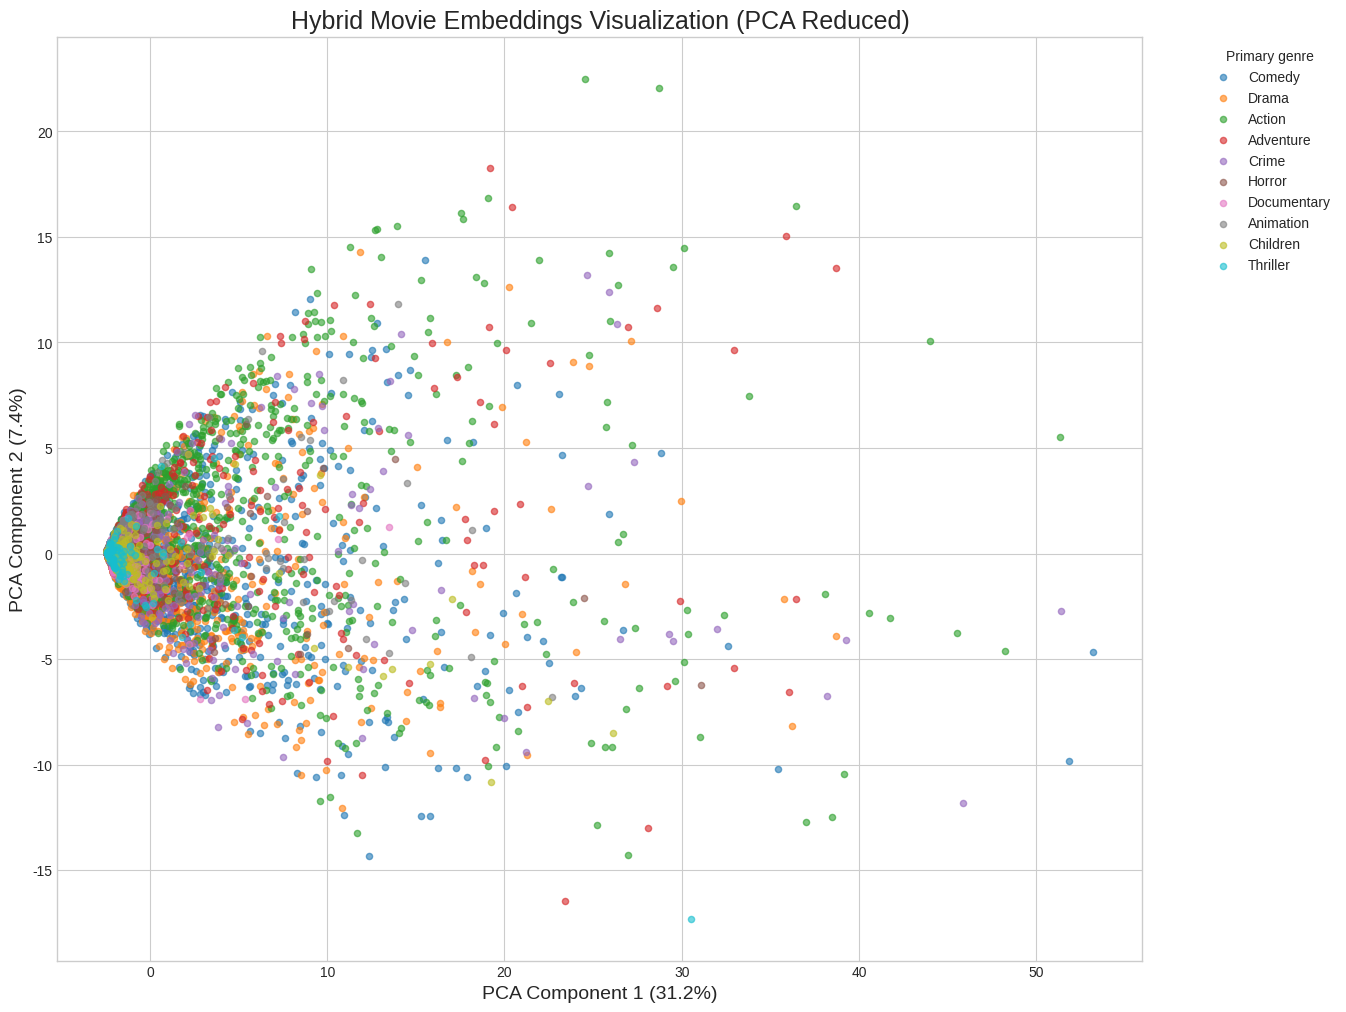

시각화 출력이 완료되었습니다.


In [9]:
# 5a. PCA 적용 (1723 features -> 2 dimensions)
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(hybrid_movie_embeddings)
pca_df = pd.DataFrame(data=pca_result, columns=['pca_1', 'pca_2'])

# 5b. 데이터 준비 및 병합
pca_df['movieId'] = all_movie_ids
visualization_df = movies_df[['movieId', 'genres']].merge(pca_df, on='movieId', how='inner')

def get_primary_genre(genres_str):
    if '|' in genres_str:
        return genres_str.split('|')[0]
    return genres_str

visualization_df['primary_genre'] = visualization_df['genres'].apply(get_primary_genre)
top_genres = visualization_df['primary_genre'].value_counts().nlargest(10).index.tolist()
plot_df = visualization_df[visualization_df['primary_genre'].isin(top_genres)]

# 5c. Matplotlib 시각화
plt.figure(figsize=(14, 12))
plt.style.use('seaborn-v0_8-whitegrid')

for genre in top_genres:
    subset = plot_df[plot_df['primary_genre'] == genre]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=genre, alpha=0.6, s=20)

plt.title('Hybrid Movie Embeddings Visualization (PCA Reduced)', fontsize=18)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=14)
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=14)
plt.legend(title='Primary genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.show()
print("시각화 출력이 완료되었습니다.")

6. 최종 결과 저장

In [10]:
np.save('hybrid_movie_embeddings.npy', hybrid_movie_embeddings)
np.save('final_movie_ids.npy', all_movie_ids)

print("\n=======================================================")
print("✨ Step 2: 최종 영화 하이브리드 임베딩 생성 및 저장 완료 ✨")
print(f"총 영화 수: {n_movies}개")
print(f"총 임베딩 차원: {hybrid_movie_embeddings.shape[1]} 차원 (50 + {n_tag_features})")
print(f"저장 파일: 'hybrid_movie_embeddings.npy'")
print("=======================================================")


✨ Step 2: 최종 영화 하이브리드 임베딩 생성 및 저장 완료 ✨
총 영화 수: 9742개
총 임베딩 차원: 1723 차원 (50 + 1673)
저장 파일: 'hybrid_movie_embeddings.npy'
